# Bayesian Inference $\rightarrow$ Variational Inference $\rightarrow$ Active Inference 

In [1]:
from matplotlib import pyplot as plt
import numpy as np

You are sat in your London office and its time to go get lunch at the cafe down the road. You want to know whether it is raining so you can decide if you should bring your umbrella for the journey. From past experience you know in England it rains quite often, but you can't be sure. You need more information. You look to the window but sadly the office windows are frosted and you can only get a sense for how light it is outside. You reason that lower the light levels outside the more likely it is that is raining. You see its looking quite dark outside, so you take your umbrella.

Over in California another person in an identical situation sees low light levels out of the frosted window. They don't take their umbrella, it's probably just a bit cloudy.

During this process you are trying to reason about an unknown state of the world (is it raining). To do this you start with your prior knowledge of the world (what country you are in, the time of day, the time of year etc). You then make some new observation (outside light levels). 
You then combine your prior knowledge along with your beliefs about how the states of the world would produce your observations (raining outside would make it more likely for you to observe low light levels) to form a final belief of your confidence in the state. 

The process of combining prior beliefs with current observations to reason about states of the world is known as bayesian inference. In this post I aim to introduce some of the maths involved with bayesian inference using the simple example outlined above. I will then go on to describe Variational Inference, a common method for performing approximate bayesian inference. This is a small starting point for understanding a general theory for how animals reason about and act upon the world: Active Inference. 

## Some prerequisites 

- The sum rule of probability: $p(x) = \sum_{y} p(x, y)$, or $p(x) = \int_{y} p(x, y)dy$ in the continuous case
- The product rule of probability: $p(x, y) = p(y|x)p(x) = p(x|y)p(y)$
- Bayes rule which comes directly from the product rule: $p(x|y) = \frac{p(y|x)p(x)}{p(y)}$
- The laws of logs: $\log a + \log b = \log ab$ and $\log a - \log b = \log \frac{a}{b}$
- The expectation of a function $f(x)$ under a probability distribution $p(x)$: $\mathbb{E}_{p(x)}[f(x)] = \sum_{x} p(x)f(x)$ or $\mathbb{E}_{p(x)}[f(x)] = \int_{x} p(x)f(x)dx$ in the continuous case

## An example of bayesian inference

To make the qualitative description in the introduction more concrete lets define some notation to allow us to do bayesian inference.

- We have an agent which believes the outside environment can be in one of the 2 states, $s\in \{\text{rain}, \text{no rain}\}$. 
- Each of these states can cause one of 3 possible observation of the light levels, $o \in \{\text{low}, \text{med}, \text{high}\}$, 
- The agent has some prior beliefs about the probability of each state, $p(s)$. In this example this is a Bernoulli with a single parameter $p$: $p(s=\text{rain}) = p$ and $p(s=\text{no rain}) = 1-p$.
- The agent has a model of how likely all observations are given a certain state: $p(o|s)$. We can represent this with a matrix $\bf{A}$, with entries $A_{ij} = p(o=i | s=j)$. You can view the columns of $\bf{A}$ as the likelihood of each state given an observation and rows as a probability distribution over observations given a state. In this case we have a matrix with 2 rows and 3 columns, mapping the 2 possible states to the 3 possible observations.

The agent can make an observation and then update its beliefs about the states using bayes rule.
Another way to say this is that the agents prior beliefs $p(s)$ are updated to form posterior beliefs $p(s|o)$ in response to some sensory information by the use of the agents model of likelihood attributed to observations of given states, $p(o|s)$. This can be written down as bayes rule:

$$ \underbrace{p(s|o)}_{\text{Posterior}} = \frac{\overbrace{p(o|s)}^{\text{Likelihood}}\overbrace{p(s)}^{\text{Prior}}}{\underbrace{p(o)}_{\text{Evidence}}} = \frac{p(o|s)p(s)}{\sum_{s}p(o|s)p(s)}$$ 

The following code defines a prior and likelihood matrix and for each possible observation plots the prior, likelihood, and posterior. 

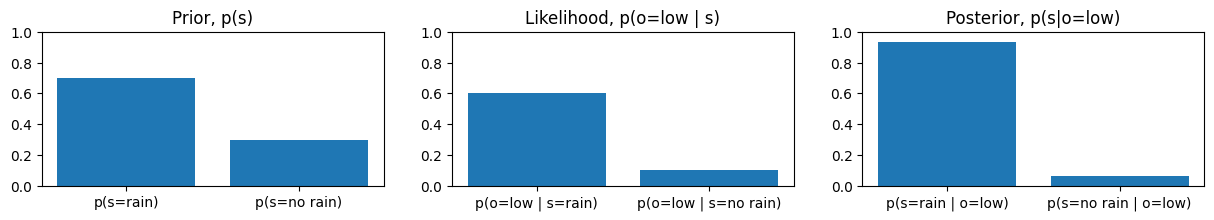

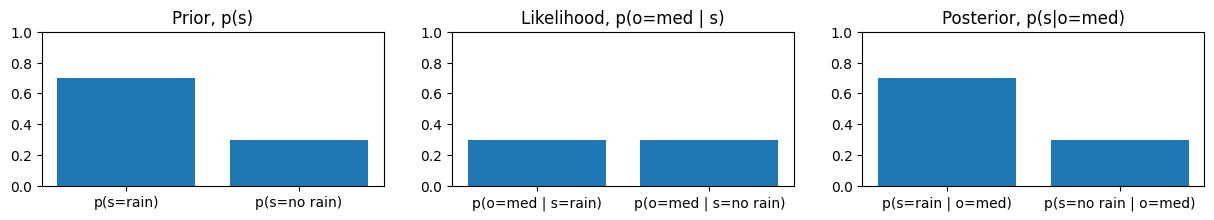

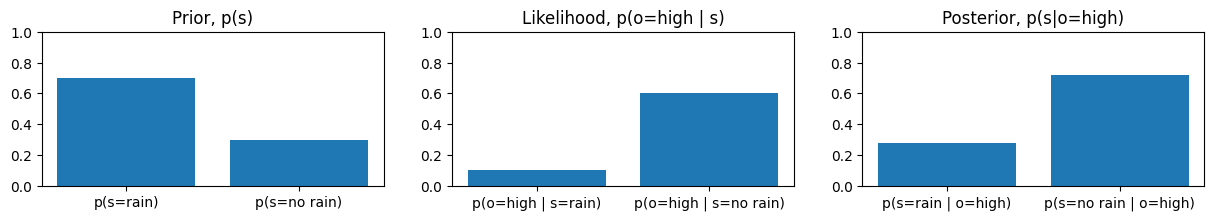

In [2]:
prior = np.array([0.7, 0.3]) # p(s=rain) = 0.7, p(s=no rain) = 0.3
A = np.array( # Likelihood mapping from states to observations
    [
        [0.6, 0.3, 0.1],  # Prob for observations o=low, o=med, o=high when in state s=rain
        [0.1, 0.3, 0.6],  # Prob for observations o=low, o=med, o=high when in state s=no rain
    ]
)

for i, observation in zip([0, 1, 2], ["low", "med", "high"]):
    likelihood = A[:, i] # p(o|s)
    evidence = sum(likelihood * prior) # p(o)
    posterior = likelihood * prior / evidence # p(s|o)

    # Plot prior, likelihood and posterior
    fig, axs = plt.subplots(1, 3, figsize=(15, 2))
    axs[0].bar(x=["p(s=rain)", "p(s=no rain)"], height=prior)
    axs[0].set_title("Prior, p(s)")

    axs[1].bar(x=[f"p(o={observation} | s=rain)", f"p(o={observation} | s=no rain)"], height=likelihood)
    axs[1].set_title(f"Likelihood, p(o={observation} | s)")

    axs[2].bar(x=[f"p(s=rain | o={observation})", f"p(s=no rain | o={observation})"], height=posterior)
    axs[2].set_title(f"Posterior, p(s|o={observation})")

    for ax in axs: 
        ax.set_ylim(0, 1)

When we observe low light levels, our model assigns high likelihood to rain. When combined with the prior which assigns a high probability to rain the posterior results in a very high probability for rain. In this case the observation 'agrees' with the prior beliefs which enforces and strengthens the beliefs.

When we observe medium light level our model assigns equal likelihood to rain and no rain. This means the observation is giving us no reason to change our prior beliefs so the posterior remains unchanged from the prior.

When we observe high light levels, our model assigns low likelihood to rain. When combined with the prior which assigns a high probability to rain the posterior results in higher probability for no rain. In this case the obervations 'disagrees' with the prior beliefs so pulls our prior beliefs in the opposite direction i.e to favour no rain.

Note that the posterior probability of no rain when observing high light levels is less than the posterior probability assigned to rain when observing low light levels. This is the result of the prior beliefs moderating the likelihood, when observations confirm our priors we become even more confident in our priors, when they contradict them we change our beliefs but we are less confident.

### Model Evidence

We have seen how the prior and likelihood combine to form posterior beliefs. However, these two terms are simply an agents model of the environment and how hidden states will map to observations. If we change the agents model (i.e modify the values in the prior and $A$ matrix in the above code) we can still apply bayes rule and get different posterior beliefs which are equally valid mathematically. But then which of the two models are better? The answer to this lies in the evidence term of bayes rule.

The evidence term written above as $p(o)$ is the probability of an observation with all the hidden states marginalised out. When written simply as $p(o)$ it appears that under some fixed observation this term is always a fixed value and so not of much interest. This is indeed true however it is important to see that this only a fixed value for a given model. To make this explicit we can write the same evidence term explicitly conditioned on a model $m$. 
$$
p(o|m) = \sum_{s} p(o|s, m)p(s|m)
$$

We can view $m$ as completly defining the parameteres and structure of the agents model. In the example we simply imposed this structure when defining notation, asserting the prior as a Bernoulli with high belief that it is raining and the likelihood as a 2x3 matrix with a value for each state/observation pair assigning high likelihood that low light corresponds to rain and visa versa. This structure and values are modelling choices which seems to suit the example, but are not necessarily the best description of the observation made of the light level.

This explicit conditioning on the model $m$ is often left out for brevity of notation but it reveals the evidence as the probability of observations under a given model for how the observations were generated. Models which assign a higher probability to observations are more in line with reality and provide a better explanation for the observed data. Comparing the model evidence of different types of model under some fixed data is known as Bayseian model comparision.

Going back to the example, our chosen model assigns high prior probability to rain and a high likelihood to rain if low light levels are observed. Therefore if we observe high light levels (a quite unexpected observation under this particular model) we could say this model is worse than if we had a model with a prior assigning high probability to no rain OR the same prior but a likelihood assigning a higher probability of rain when high light levels are observed. It therefore makes sense that the model will assign the highest evidence to the observation of low light levels as they are expected and low evidence to high light levels as they are unexpected. 

To see the effect of changing our model we plot a heatmap showing the model evidence for a range of prior probiilties for rain and a range of likelihood of rain given we observe low light levels. You can see that if we oberserve low light levels, the models with the highest evidence assign a very high prior to rain and a high likelihood to rain given the observation of low light. By symmetry models which assign a low prior to rain and low likelihood to rain given low light have equally high model evidence. Which of these models is actually more appropriate would then depend on other information, e.g the former might be a good model for London (often raining, often cloudy) and latter might be a good model for Los Angeles (rarely rains, even if it is cloudy). This information would feed into the prior, and once that is defined the likelihood which gives high model evidence will become clear. 

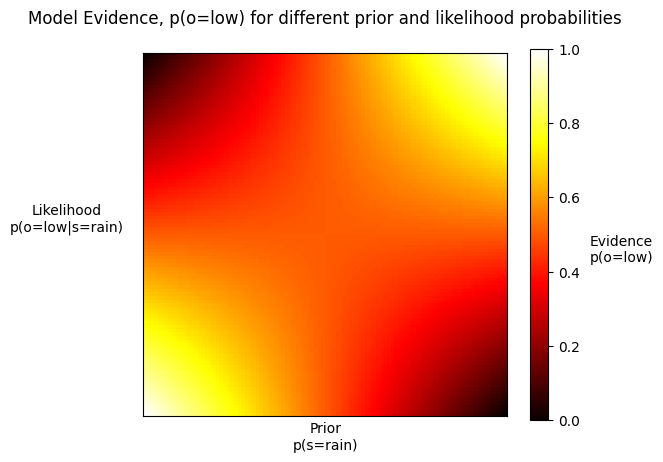

In [9]:
grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
evidences = np.array([])

for l, p in zip(grid[0].flatten(), grid[1].flatten()):
    _likelihood = np.array([l, 1 - l]) # [p(o=low|s=rain), p(o=low|s=no rain)]
    _prior = np.array([p, 1 - p]) # [p(s=rain), p(s=no rain)]
    _evidence = sum(_likelihood * _prior)
    evidences = np.append(evidences, _evidence)

fig, ax = plt.subplots()
evidences = np.array(evidences).reshape(100, 100)[::-1, :]
im = ax.imshow(evidences, cmap='hot')
ax.set_title("Model Evidence, p(o=low) for different prior and likelihood probabilities\n")
ax.set_xlabel("Prior\np(s=rain)")
ax.set_ylabel("Likelihood\np(o=low|s=rain)", rotation=0, labelpad=55)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label(label="Evidence\np(o=low)", rotation=0, labelpad=30)
ax.set_xticks([]), ax.set_yticks([])
fig.tight_layout()

### Surprise 

The above discussion of model evidence presents it as dependent on the choice of model given some fixed set of observations. If instead we say the model is fixed (we have chosen a structure and parameters we are happy with) viewing the values of evidence for different observations gives another interpretation of evidence: surprise. First lets look at the evidence for each oberservation. The evidence for observing high light levels is 0.25 meaning that given our model we would expect to see high light levels 25% of the time, but low light levels more frequently at 45% of the time. This is equivalent to say that we would be more surprised to see high light levels under our model. This surprise can be quantified as negative log evidence, $-\log p(o)$ where high values are more surprising observations.

In [4]:
evidences = np.sum(A.T * prior, axis=1).round(2)
for observation, evidence in zip(["low", "med", "high"], evidences):
    print(f"Evidence: p(o={observation}) =", evidence)
    print(f"Surprise: -log p(o={observation}) = {round(-np.log(evidence), 2)}\n")

Evidence: p(o=low) = 0.45
Surprise: -log p(o=low) = 0.8

Evidence: p(o=med) = 0.3
Surprise: -log p(o=med) = 1.2

Evidence: p(o=high) = 0.25
Surprise: -log p(o=high) = 1.39



### Model evidence as the likelihood for model selection


Instead of choosing the best model as the one with the highest model evidence we can employ bayesian inference yet again. We start with a prior over model types $p(m)$. The likelihood is exactly the model evidence $p(o|m)$ as defined above, giving the probability of an observation of light levels under the model $m$. With this we can form a posterior distrubution over model types:


$$ \underbrace{p(m|o)}_{\text{Posterior over models}} = \frac{\overbrace{p(o|m)}^{\text{Model Evidence}}\overbrace{p(m)}^{\text{Prior}}}{p(o|M)}$$ 


This shows that selecting the model with the highest evidence is actually doing maximum likelihood estimation over models. But with a full bayesian treatment you get a distribution over models from which you can sample models.

The denominator here is not now model evidence and has a different meaning emphasised by conditioning on a new quantity $M$ representing some higher level aspect of the model construction. For example we could say that $m$ spans all possible values in a 2x3 matrix to form the likelihood, but $M$ spans the space of all possible types of model we could choose for the likelihood function mapping obervations to a likelihoood value for each state (2X3 matrix, logistic regression model, deep neural network etc). What emerges is a heirarchy of bayesian modeling where the evidence term in bayes rule is conditioned on higher and higher level abstractions. Of course in practice these higher level abstractions such as model family selection is done by humans, but they themselves have performed some form of bayesian reasoning to make their decisions in the first place (e.g "I will use a transformer not a linear regression for language modelling becuase I have strong prior knowledge that a linear model won't work well")  

## Variational Inference 

In such a simple example directly computing the posterior with bayes rule is the easiest way to update beliefs in response to observations. However in more realistic scenarios this is not possible. The problem is that the evidence term, which invovles summing over all possible states becomes computationally intractable when the state space becomes large.

$$p(o) = \sum_{s} p(o,s) = \sum_{s} p(o|s)p(s)$$


To get around this intractibilty there are numerous ways to approximate the true posterior but here we focus on variational inference due to it's use in Active Inference. 

In a sentence, variational inference finds an approximation of the true posterior by first creating a simple (but flexible) distribution and optimising the parameters of this distribution so it is as close as possible to the true posterior. This approach casts bayesian inference as an optimisation problem.

The simple distribution that we create we will call the variational distribution, $q(s)$. We now need to define a measure of distance between $q(s)$ and the true posterior $p(s|o)$. The Kullback–Leibler (KL) Divergence is used for this, it gives a strictly positive measure of the difference between probability distributions, with a value of 0 only if the two distributions are identical. The KL Divergance between the variational distribution and true posterior is defined as:

$$
D_{KL}[q(s)||p(s|o)] = \sum_{s} q(s) \log\frac{q(s)}{p(s|o)}
$$

When $q(s)=p(s|o)$ this becomes $\sum_{s} q(s) \log1 = 0$.

So now we just need to adjust the parameters of $q(s)$ so that this quantity is 0 (or close to 0). But how can we do this? The equation above contains the the true posterior and we don't know this, its exactly what we are trying to find. In this form we cannot minimise this function.

To get around this we need to do some algebra, starting with the definition above we get:

$$
\begin{split}
D_{KL}[q(s)||p(s|o)] &= \sum_{s} q(s) \log\frac{q(s)}{p(s|o)} \\
                     &= \sum_{s} q(s) \log\frac{q(s)p(o)}{p(s, o)} \\
                     &=\underbrace{\sum_{s} q(s) \log\frac{q(s)}{p(o, s)}}_{\mathcal{F}} + \log p(o)
\end{split}
$$

The first step uses bayes rule $p(s|o)=\frac{p(o,s)}{p(o)}$. The second step uses the identity of $\log{ab}=\log{a} + \log {b}$ and the fact that $p(o)$ is independent of s and $\sum_{s}q(s) =1$ so $\sum_{s}{q(s) \log p(o)} = \log p(o)$.

The issue with minimising the KL term on the left directly is that we don't know the true posterior p(s|o) (if we did we would be done anyway!)

The final term is the model evidence, another term which is intractable. Again if we could compute the evidence we would be OK as we could simply use bayes rule directly to compute the posterior.

The 1st term on the right is known as the "variational free energy" $\mathcal{F}$ and is composed of terms that we actually have access to (the joint and variational distributions).

The free energy is commonly written in the following two equivalent forms:

$$
\begin{split}
\mathcal{F} &= \underbrace{D_{KL}[q(s)||p(s|o)]}_{\text{Divergence}} - \underbrace{\log p(o)}_{\text{Evidence / Surprise}} \\
  &= \underbrace{D_{KL}[q(s)||p(s)]}_{\text{Complexity}} - \underbrace{\mathbb{E}_{q(s)}[\log p(o | s)]}_{\text{Accuracy}}
\end{split}
$$

The first form is just the previous equation rearranged. It shows that if we can find a $q(s)$ which is exactly equal to the true posterior the divergence term becomes zero and the free energy becomes exactly equal to the evidence. This shows free energy as a lower bound on the model evidence. The negative free energy is often called the Evidence Lower Bound or the ELBO in machine learning. Another interpretation of the negative log evidence is surprise and so the free energy is also said to be an upper bound on surprise.

Given that under some obervations the evidence term is fixed, lowering the value of $\mathcal{F}$ will necessarily be also lowering the divergence term. This means we can minimise $\mathcal{F}$ term as a proxy for minimising the KL divergence term. Finding the q(s) which minimises variational free energy is known as "Variational Inference".

The final form here shows that in minimising free energy we are looking for an approximate posterior which is minimally complex (similar to our prior beliefs about states s) while also being highly accurate (maximising the likelihood of our observations o).
This is a useful form as unlike the Divergence/Evidence form it is composed of terms we can compute (the prior, the likelihood and the variational posterior). This form is commonly used as the objective/loss function which is optimised to perform variational inference. For example this is exactly the loss function which is used to train variational autoencoders.

### Back to the example

To perform variational inference in our toy example we first need to choose a variational distribution, $q(s)$. Since we just have 2 states the easy choice is a Bernoulli distribution with a single parameter $p$, where $q(s=\text{rain}) = \text{p}$ and $q(s=\text{no rain}) = 1- \text{p}$. The task is now optimising the parameter of this distribution to minimise the variational free energy. 

In the code below we define a function to compute the free energy and plot the value of this function across the full parameter space of our variational distribution (p ranging from 0 to 1). In this case we can also directly compute the negative log evidence terms plot these.

Text(0.5, 1.0, 'Variational free energy as a function of approximate posterior parameter p')

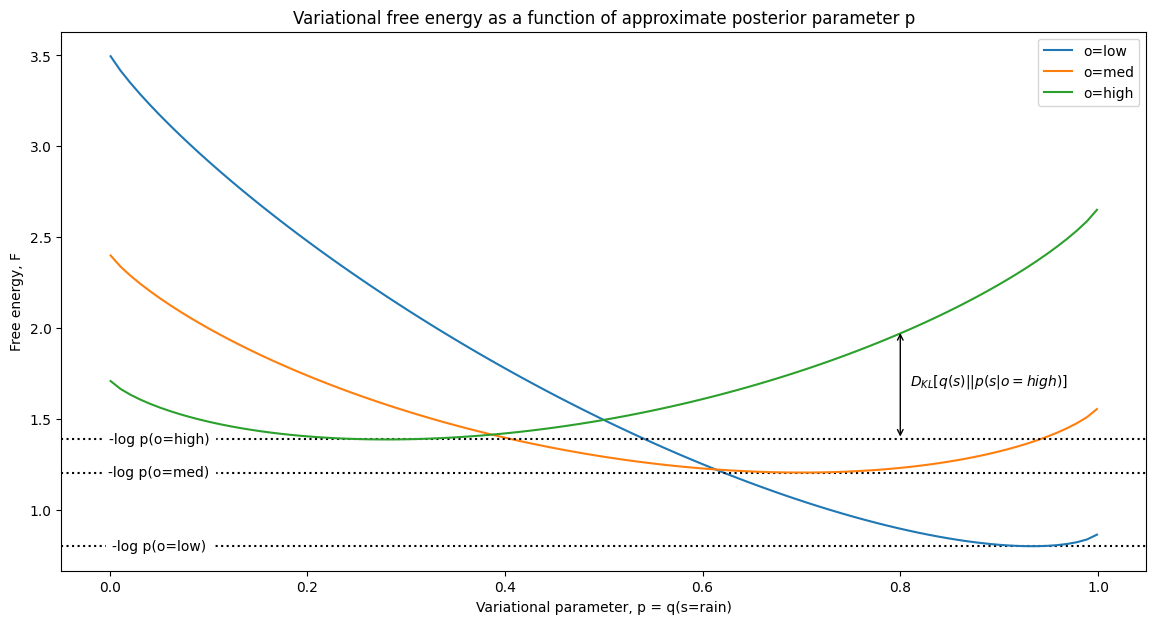

In [5]:

# Define how variational free energy is calculated from a given q_s
F = lambda q_s, likelihood, prior: sum(q_s * np.log(q_s / (likelihood * prior)))

# Compute F for arange of parameter p
es = {"o=low": [], "o=med": [], "o=high": []}
parameter_space = np.linspace(0.001, 0.999, 100)
for p in parameter_space:
    q_s = np.array([p, 1 - p])
    es["o=low"].append(F(q_s, A[:, 0], prior))
    es["o=med"].append(F(q_s, A[:, 1], prior))
    es["o=high"].append(F(q_s, A[:, 2], prior))

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# In this simple example we can directly compute the  negative log evidence (surprise)
neg_log_evidence = lambda observation: -np.log(sum(A[:, observation] * prior))
for i, observation in zip([0, 1, 2], ["low", "med", "high"]):
    neg_le = neg_log_evidence(i)
    ax.axhline(neg_le, 0, 1, color="k", ls=":")
    ax.text(0.05, neg_le, f"-log p(o={observation})", fontsize=10, va='center', ha='center', backgroundcolor='w')
    ax.plot(parameter_space, es[f"o={observation}"], label=f"o={observation}")

# Annotate the KL divergence 
ax.annotate(text="", xy=(0.8, es[f"o=high"][80]), xytext=(0.8,neg_log_evidence(2)), arrowprops=dict(arrowstyle='<->'))
ax.annotate(text='$D_{KL}[q(s)||p(s|o=high)]$', xy=(0.8, es[f"o=high"][80]), xytext=(0.81, neg_log_evidence(2) + 0.3))

ax.set_xlabel("Variational parameter, p = q(s=rain)")
ax.set_ylabel("Free energy, F")
ax.legend()
ax.set_title("Variational free energy as a function of approximate posterior parameter p")

There are 3 key observations to made from the above plot:

- The minimum of the free energy corresponds to a value of variational parameter, p, giving a distribution $q(s)$ exactly equal to the true posterior found from exact bayesian inference. You can read off the values of p which minimises $F$ for each observation and confirm that they correspond to the values of the true posterior $p(s=\text{rain}|o)$ shown in plots in the previous section. Given we have a 1D parameter space we can simply plot and read off the minima, but in practice the optimisation can be done by performing gradient descent on the free energy. 

- When the free energy is minimised it becomes exactly equal to the negative log evidence. This is because we have managed to set the KL Divergence between the variational and true posterior to exactly 0, leaving only the evidence term in the definition of free energy. When the parameter p does not correspond to the exact posterior the KL divergence is the gap between negative log evidence and free energy, an example of this is marked on the plot. The fact we can make this divergence exactly 0 is due to the simplicity of the example. When things become more complex our choice of variational posterior may not be able to fully capture the shape of the true posterior so the free energy minima might be above the negative log evidence. 

- The negative log evidence has different values for different observations. As described before this quantity is also known as surprise and you can see that the least surprising observation under our model is low light. The key thing here is that infact there are two things which effect how far variataional free energy can be minimised: The approximate posterior and the observations we make. Optimising the parameters of the appoximate posterior minimises the KL term in the free energy but does not effect the evidence term. Before we have said the evidence term is constant given some fixed observations (and fixed model). But what about if we change the observations? Minimising free energy in these two ways relates directly to perception and action in Active Inference and is discussed later on. 


In summary, we have seen that approximate Bayesian inference can be posed as an optimisation problem. We first define an approximate posterior distribution and adapt its parameters to make it close to the true posterior distribution. In reality we can't compute this closeness directly but we can by proxy by minimising a quantity known as the variational free enery which provides a lower bound on the model evidence.

## Variational inference in machine learning - Examples

### A Bayesian neural network 

We can view a neural network as a probabilistic model, which given an input $\bf{x}$ and a set of weights $\bf{w}$, will assign a probability to each possible output $\bf{y}$: $p(\bf{y}| \bf{x}, \bf{w})$. For a classification problem this is a categorical distribution over all the classes, corresponding to a cross-entropy or softmax loss. For regression $p(\bf{y}| \bf{x}, \bf{w})$ is a gaussian distribution, corresponding to a squared loss [7]. We can show this as the following probabilistic graphical model. The circles with the shaded background indicate observed variables (the data) and the other is unobserved (the network weights).  The plate with the N in the corner is showing there are N independent instances of these variables (for each datapoint in the dataset).

![img/bayes_nn.jpeg](img/bayes_nn.jpeg)
<img src="img/bayes_nn.jpeg" alt="Drawing" style="width: 1000px;"/>

The weights of the network can be learnt by maximum likelihood estimation (MLE). Given a training dataset of inputs and labels  $\mathcal{D} = (\bf{x}_i, \bf{y}_i)_i$, MLE is performed by finding the value of $\bf{w}$ which maximises $p(\mathcal{D}|\bf{w})$:

$$
\begin{split}
\bf{w}^{MLE} &= \underset{\bf{w}}{\text{argmax}}\log \mathnormal{p}(\mathcal{D}|\bf{w}) \\
             &= \underset{\bf{w}}{\text{argmax}} \sum_{i} \log \mathnormal{p}(\bf{y}_i| \bf{x}_i, \bf{w})
\end{split}
$$

This is equivalent to just training a neural network with a standard mean squared or cross entropy loss. We can make things a bit more bayesian by finding the maximum of the posterior distribution (maximum a posteriori or MAP):

$$
\begin{split}
\bf{w}^{MAP} &= \underset{\bf{w}}{\text{argmax}}\log \mathnormal{p}(\mathcal{D}|\bf{w}) \mathnormal{p}(\bf{w}) \\
             &= \underset{\bf{w}}{\text{argmax}} \sum_{i} \log \mathnormal{p}(\bf{y}_i| \bf{x}_i, \bf{w}) + \log \mathnormal{p}(\bf{w})
\end{split}
$$

This is equivalent to  training a neural network with some regularisation term on the weights. 

However for a full bayesian treatment of this model we are not after just a point estimate of weights which maximise the likelihood or posterior. What we want is the full posterior distribution over the weights given the training data. In other words, starting from some prior beliefs about what the weights could be, we want to update these beliefs with the use of the likelihood to form posterior beliefs about the parameters. We can write this as Bayes rule:

$$
p(\bf{w}| \mathcal{D}) = \frac{\mathnormal{p}(\mathcal{D}|\bf{w})\mathnormal{p}(\bf{w})}{\mathnormal{p}(\mathcal{D})} = \frac{\mathnormal{p}(\mathcal{D}|\bf{w})\mathnormal{p}(\bf{w})}{\int_{\bf{w}}\mathnormal{p}(\mathcal{D}|\bf{w})\mathnormal{p}(\bf{w})\text{d}\bf{w}}
$$


The numerator of the fraction is easy for us to compute, we can choose a simple prior over the weights (for exmaple a gaussian with mean 0 and precision 1), and a likelihood function (gaussian for regression, categorical for classification). However, as ever the the evidence term requires an intractable integral over the entire weight space of the network, so we cannot find this normalising constant easily. One approach is then to use variational inference. We propose a distribution over the weights parameterised by $q_{\theta}(\bf{w})$ (the variational posterior), then the task becomes finding the $\theta$ which minimises the KL-divergence between $\theta$, $q_{\theta}(\bf{w})$ and the true posterior $p(\bf{w}| \mathcal{D})$. From the previous section we have shown that this is equivalent to minimising the variational free energy (or evidence lower bound, ELBO) so we can write down the optimal parameters as 

$$
\begin{split}
\theta^* &= \underset{\theta}{\text{argmin}} \space \mathcal{F} \\
         &= \underset{\theta}{\text{argmin}} \space \underbrace{D_{KL}[q_{\theta}(\bf{w})||\mathnormal{p}(\bf{w})]}_{\text{Complexity}} - \underbrace{\mathbb{E}_{q_{\theta}(\bf{w}))}[\log p(\mathcal{D} | \bf{w})]}_{\text{Accuracy}}
\end{split}
$$

The variational free energy gives us a loss function to optimise to find the parameters of the posterior distribution. This optimisation can be achieved with backpropapgation, see the 'Bayes by Backprop' paper for more details on this [7].

How can predictions be made with this model? If we have the true posterior we can sample a set of weights from the posterior and then pass input samples through this network. However the more comprehensive way is making a model prediction for every possible combination of weights but each prediction is weighted by the posterior probability of the given weights for that prediction. Another way to say this is a prediction is the expectaion of the model predictions under the posterior distrubution over weights. Given we have a new sample $\hat{x}$ and we want to generate the predictive distribution of the unknown label $\hat{y}$ we can write this down as:

$$
\begin{split}
p(\hat{y} | \hat{x}, \mathcal{D}) &= \mathbb{E}_{\mathnormal{p}(\bf{w} | \mathcal{D})}[p(\hat{y} | \hat{x}, \bf{w}) ] \\
                            &=\int_{\bf{w}} p(\hat{y} | \hat{x}, \bf{w}) \mathnormal{p}(\bf{w} | \mathcal{D})\text{d}\bf{w} 
\end{split}
$$

This is known as the bayesian model average.


In practive we dont have access to the exact posterior and intergrating over the whole weight space is intractable. We can approximate the bayesian model average by taking N samples of weights from the learned variational posterior and making N model predictions, and avergaing them:
$$
p(\hat{y} | x, \mathcal{D}) \approx \frac{1}{N}\sum_{i=1}^{N} p(y | x, \bf{w}_i),   \bf{w}_i \sim q_{\theta}(\bf{w})
$$


### Variational inference using an autoencoder

In our intial example we had a generative model for observations (light levels through a window) which were produced from unobservable states of the world (rain or no rain outside). Inference of the model involved finding a distribution over the unobservable states given some observations. Here we present this model a bit more generally and give a tractable way to perform variational inference on it, the Variational Auto-Encoder (VAE) [8].

We have a dataset of N samples $\bf{x}_i$ of a random variable $\bf{x}$. We say that each $\bf{x}_i$ is generated by some process which depends on some latent random variable $\bf{z}$. First a value of $\bf{z}_i$ is drawn from some prior distribution over $\bf{z}$, $p(\bf{z})$, and then the observed data point is then sampled from the conditional distribution $p(\bf{x}|\bf{z})$. We can parameterize this generative model with parameters $\theta$ and write down the joint distribution over observed and latent variables:

$$
p_{\theta}(\bf{x}, \bf{z}) = \mathnormal{p}_{\theta}(\bf{x} | \bf{z})\mathnormal{p}_{\theta}(\bf{z})
$$

From this model we only have access to the observed data, the values of the corresponding latent variables $\bf{z}_i$ and the true model parameters $\theta$ are unobserved. Again we can write down bayes rules which will directly give us the posterior distribution over the latent variable

$$
p_{\theta}(\bf{z}| \bf{x}) = \frac{\mathnormal{p}_{\theta}(\bf{x} | \bf{z})\mathnormal{p}_{\theta}(\bf{z})}{\int_{\bf{z}}\mathnormal{p}_{\theta}(\bf{x} | \bf{z})\mathnormal{p}_{\theta}(\bf{z})\mathnormal{d}\bf{z}}
$$

As ever the evidence term requires an intractable integral (when the latent space is large) so we resort to variational inference. We propose a variational posterior over the latent space with parameters $\phi$, $q_{\phi}(\bf{z}|\bf{x})$.

This setup can be represented by the following graphical model, where the solid lines represent the generative model and the dashed show the variational posterior. The plate with the N in the corner is showing there are N independent instances of these variables (for each datapoint in the dataset). The parameters outside the box are fixed across the N datapoints. The circle with the grey background is indicating the variable is observed.


<!-- ![img/vae.jpg](img/vae.jpg) -->

<img src="img/vae.jpg" alt="Drawing" style="width: 1000px;"/>

Copied from the paper [8]


We would like to minimise the KL divergence between the variational posterior and the true intractable posterior. We have seen this can be achieved by minising the variational free energy which in this case is written as a funciton of the data and parameters of both the generative model and the variational posterior:

$$
\begin{split}
\mathcal{F(\theta, \phi; \bf{x})} &= \space \underbrace{D_{KL}[q_{\phi}(\bf{z}|\bf{x})||\mathnormal{p}_{\theta}(\bf{z})]}_{\text{Complexity}} - \underbrace{\mathbb{E}_{q_{\phi}(\bf{z}|\bf{x})}[\log \mathnormal{p}_{\theta}(\bf{x} | \bf{z})]}_{\text{Reconstruction Error}}
\end{split}
$$

If we interpret the latent space as some form of encoding of our data, we can view the variational posterior as a probabilistic encoder which maps a data point $\bf{x}_i$ to a distribution of possible values for $\bf{z}$. Similarly we can view the likelihood $\mathnormal{p}_{\theta}(\bf{x} | \bf{z})$ as a probabilistic decoder mapping a latent value $\bf{z}_i$ to a distribtion over possible values of $\bf{x}$. With this in mind we can give and interpretation of the two terms which define $\mathcal{F}$:
 - Complexity: this ensures the variational posterior remains close to some prior distribution which we choose ($\mathcal{N}(0, 1)$ for example). This can be interpreted as a regularisation term, keeping the learnt distribution simple structured and continuous.
 - Reconstruction error: measures the similarity between the data point and the result of encoding and then decoding the datapoint. This is the standard loss function of an autoencoder.


Notice how in this section we have not yet mentioned neural networks. This is delibrate to emphasise that the model and thoery described is not tied to deep learning models. In fact in the original VAE paper [8] the use of a neural networks is just given as an example of the method of variational inference using an autoencoding scheme. 

To illustrate this, we can say that the variational posterior models a multivariate Gaussian with a diagonal covariance:
$$
\begin{split}
q_{\phi}(\bf{z}|\bf{x}) &= \mathcal{N}(\bf{z}; \bf{\mu}_e, \bf{\sigma}_e^2\bf{I}) \\

\begin{bmatrix} \bf{\mu}_e \\ \log \bf{\sigma}_e^2 \end{bmatrix} &= g_{\phi}(\bf{x})
\end{split}
$$

where the mean and standard deviation are given by the output of a neural network, $g_{\phi}(\bf{x})$ with parameters $\phi$ (the 'encoder'). Note that if we also choose a simple normal distrition for the prior $p(\bf{z})$ the complexity term of $\mathcal{F}$ can be written down in closed form (see paper for derivation and result).

For continuous data we can model the log likelihood as a Gaussian with the mean being the output of a neural network $\mathnormal{f}_{\theta}(\bf{z})$ with parameters $\theta$. This reveals the Reconstruction Error term in $\mathcal{F}$ as a squared loss.


$$
\begin{split}
 \log p_{\theta}(\bf{x}|\bf{z}) &= \log\mathcal{N}(\bf{x}; \bf{\mu_d}, \bf{\sigma_d}^2\bf{I}) \\
                          &= \log \mathcal{N}(\bf{x}; \mathnormal{f}_{\theta}(\bf{z}), \sigma_d^2\bf{I}) \\
                          &\sim || \bf{x} -  \mathnormal{f}_{\theta}(\bf{z})||^2
\end{split}
$$

To pull this together the training of the model can be done as follows:
- Pass a data point $\bf{x}_i$ through the encoder network to get the mean and variance of the latent space distribution, $\begin{bmatrix} \bf{\mu}_e, \log \bf{\sigma}_e^2 \end{bmatrix}^T = g_{\phi}(\bf{x})$.
- Sample a $\bf{z}_i \sim \mathcal{N}(\bf{z};\mu_e,\bf{\sigma}_e^2)$
- Pass the sampled z through the decoder network to get a reconstructed data point, $\bf{\hat{x}_i} = \mathnormal{f}_{\theta}(\bf{z}_i)$.
- Compute $\mathcal{F}$ and back propagate its gradients though both the encoder and decoder to update $\theta$ and $\phi$. (Back propagating through a random sampling step can be done using the reparametrisation trick, section 2.4 of the paper [8])

With this scheme we are doing two things simultaneously, performing variational inference by optimising the parameters $\phi$ of the variational posterior and learning the parameters $\theta$ of the generative model of the data.


### Contrasting Bayesian NN and VAE

The two examples outlined above both use neural networks but have some key differences.

In a Bayesian neural network we start from the point of having a network and we view it's weights as random variables which follow some distribution. The inference we are making is on the weights of the network given some data. The result of training such a network is a posterior distrubution over the weights of the network.

In a VAE we start from a generative model which maps some latent space to our observed data. The inference that is being performed is on the latent space and not the parameters of any neural network. Instead a neural network is used to learn the parameters of the posterior distribution and a second is used to learn the parameters of the generative model. These networks are trained by ML or MAP as the result of a trained VAE is a point estimate for the parameters. Therefore, a VAE is not a Bayesian neural network. Of course it is possible to extend the inference to get a posterior over the parameters of the encoder and decoder networks, this model is known as a Bayesian VAE. 

## Active inference

### Generative model and generative process 

We can start with an agent in a environment. The agent has the ability to observe the environment by collecting sensory data (sight, sound, touch etc), however the environment can hold many states which are not directly knowable to the agent. You could argue that everything in the environment is not directly knowable as all the agent can do is observe and so is restricted by the fidelity of its observation. The agent also has the ability to act in the world. Actions could be as subtle as moving the visual gaze slightly to see what is in a different direction, or more obvious actions such as moving objects around or changing its location. The effect of an action is that it will in some way cause the environment to transisiton to a new state which will in turn create some different observation the agent can make.

This scheme can be summarised in the figure below. We have the agent (left) which can make an observation $o$ of the environment (right). This observation has in reality be generated by some _generative process_ from the true state of the environment $s^*$. The agent does not have access to the true state, or the generative process of the environment but instead holds a _generative model_ of the states and observations in it's head. The agent selects an action, $u$ to make in the environment which influences the true hidden states which then generates a new observation. The agent can use its model to reason about its uncertainty of the true state of the environment and then select new actions accordingly.

<img src="img/model_and_process.jpeg" alt="Drawing" style="width: 1000px;"/>

Copy of figure 2.2 in the active inference book [1]

### Minimizing free energy 

A key assumption underpinning active inference is that agents minimize the variational free energy of their observations. To understand this we can considerd the generative model in the figure above with observations accessible to the agent and hidden states which are not directly accessible. Given some obervations the agent can infer the posterior over states using an approximate posterior $q(s)$. We can write down the equation for variational free energy as

$$
\begin{split}
\mathcal{F[q(s), o]} &= \underbrace{D_{KL}[q(s)||p(s|o)]}_{\text{Divergence: Change by Perception}} - \underbrace{\log p(o)}_{\text{Surprise: Change By Action}} 
\end{split}
$$

The first term is showing how different the agents approximate beliefs about the states of the environment differ from the true posterior under its generative model. 
This term can be minimized by perception, in that given some new observation the agent can change its beliefs about the states of the environment to closer represent the true posterior. In other words the agent can perform approximate bayesian inference (variational inference) to minimize the divergence term of the free energy. Note that this term has its minimum at 0 at which point the free energy becomes an approximation to surprise. Further minimising free energy can be achieved by directly minimising surprise.

The second term is the negative log evidence or surprise. It tells us how unlikely (or surprising) an observation is under the agents generative model. This term is only dependent on oberservations (under some fixed model) and not on the agents approximate beliefs about states. To minimise this term the observations need to change to those which the agent finds less surprising. Observations only change if the true state of the environment changes leading to the generative process producing new observations. The agent has the ability to affect states in the environment through actions. 

To summarise, in response to sensory observations an active inference has two ways to minimize free energy: perception and action. Actions are made to seek out observations which are unsurprising and perception is done to change the agents beliefs to allign with the true posterior.  

In [6]:
# State transistion matrices parameterising p(s_t| s_t-1, pi)
B1 = np.array([
    [1, 0],
    [0, 1],
])
B2 = np.array([
    [0.5, 0.5],
    [0.5, 0.5],
])

# p(o|s) Likelihood mapping from states to observations. 
# Can view columns as likelihood of state give an observation 
# and rows as prob dist over observations given a state
A = np.array(
    [
        [0.1, 0.3, 0.6],
        [0.6, 0.3, 0.1],
    ]
)

# T=1
# Approx posterior
q_s_1 = np.array([0.7, 0.3])

# T=2 (the future)
# For a particular action B1

prior = B1 @ q_s_1 # q(s | pi) - new prior after state transition,
joint = A.T * prior # q(s, o| pi)
marginal = joint.sum(axis=1) # q(o|pi) - normally intractable

# p(s | o, pi)
posterior = joint / marginal[:, np.newaxis]

# evolutionary prior 
p_o = np.array([0.2, 0.8, 0.0])

future_joint = posterior.T * p_o

print(f"{prior = }")
print(f"{joint.T = }")
print(f"{marginal = }")
print(f"{posterior.T = }")
print(f"{future_joint = }")

prior = array([0.7, 0.3])
joint.T = array([[0.07, 0.21, 0.42],
       [0.18, 0.09, 0.03]])
marginal = array([0.25, 0.3 , 0.45])
posterior.T = array([[0.28      , 0.7       , 0.93333333],
       [0.72      , 0.3       , 0.06666667]])
future_joint = array([[0.056, 0.56 , 0.   ],
       [0.144, 0.24 , 0.   ]])


#### Free energy including action

We can now start to make the above qualitive description of an active inference agent a bit more concrete.

In general an active inference agent at time $t$:
- Makes an observation, $o_t$ of the environment 
- Takes an action $u_t$, causing some hidden state transition from $s_t \rightarrow s_{t+1}$
- Samples a new observation $o_{t+1}$ and the process repeats

The result is a sequence of observations $\tilde{o}$ and hidden states $\tilde{s}$ over time. The sequence of actions, $\tilde{u}$ the agent chooses to take is called a policy which is given as $\pi$.

The generative model, which now incorporates actions can be written down as  

$$
p(\tilde{o}, \tilde{s}, \pi) = p(\tilde{o}|\tilde{s})p(\tilde{s}|\pi)p(\pi)
$$

Reading this from right to left gives you the model for how a sequence of observations are made. First a policy is sampled ($p(\pi)$ - the prior over policies). Given this sequnce of actions we can sample a sequence of resulting states ($p(\tilde{s}|\pi)$ - the model of how actions effect states). These states in turn generate a sequence of observations which are available to the agent ($p(\tilde{o}|\tilde{s})$ - the model of how states create observations).

In this model both the hidden states and the policy are hidden to the agent and so need to be inferred. We do this with variational inference and define an approximate posterior over states and policies $q(s, \pi) = q(s | \pi)q(\pi)$ and then write down the variational free energy:

$$
\begin{split}
\mathcal{F} &= \sum_{s, \pi} q(\tilde{s}, \pi) \log\frac{q(\tilde{s}, \pi)}{p(\tilde{o}, \tilde{s}, \pi)} \\
            &= \sum_{s, \pi} q(\tilde{s} | \pi)q(\pi) \log\frac{q(\tilde{s} | \pi)q(\pi)}{p(\tilde{o}|\tilde{s})p(\tilde{s}|\pi)\underbrace{p(\pi)}_{\sim -G}} \geq \underbrace{-\ln p(\tilde{o})}_{\text{Surprise}}
\end{split}
$$

This gives us the objective function for an active inference agent. To minimise free energy it must choose a policy which generates a sequence of observations which minimise surprise under its generative model. Once the policy is choosen it also performs approximate Bayesian inference over the hidden states to make the free energy as close as possible to surprise. Choosing a policy means to plan a sequence of actions into the future which the agent thinks will minimize free energy. However the free energy of the future cannot be computed directly with the above equation as future observations are unknown and so $p(\tilde{o}|\tilde{s})$ cannot be evaluated.

The choice of policy is represented in the free energy equation as the prior distribution $p(\pi)$. Given our goal at any one time is to minimise variational free energy, it makes sense for us to plan actions that will generate hidden states and observations which we expect to minimise free energy: "The key idea is that if perception minimizes free energy — so should action too. This means that prior probability of a policy should be proportional to the (negative) free energy expected under that policy" [2]. This quantity, $G$, is known as the expected free energy.

## Expected free energy 

A policy $\pi$ specifies a sequence of actions from the immediate future $t+1$ to some time in the more distant future $T$. We want to find a value for the expected free energy for the policy $G(\pi)$. We can express this as a sum of the expected free energy over future time steps 

$$
G(\pi)  = G_{t+1}(\pi) + G_{t+2}(\pi) + ... + G_{T}(\pi)  = \sum_{\tau=t+1}^{T} G_\tau(\pi) \\

p(\pi | \gamma) = \sigma(-\gamma \cdot G(\pi))
$$

the second line here shows that when put through a softmax the expected free energy can by converted to a probability distribution over policies. The parameter $\gamma$ is a precision parmeter which determines the confidence in beliefs about policies. High precision implies large probability on favoured policy (exploitation), low precision implies uniformly spread beliefs about policies (exploration). This distribution will assign high probability to policies with the lowest expected free energy.


To reason about what form $G_\tau(\pi)$ takes lets start by writing down the equation for variational free energy for a given policy at the present time $\tau=t$. 

$$
\mathcal{F}[t] = \mathbb{E}_{q(s_t|\pi)}[\ln q(s_t|\pi) - \ln p(o_t, s_t|\pi) ] = \sum_{s} q(s_t | \pi ) \ln\frac{q(s_t | \pi)}{p(o_t, s_t | \pi)}
$$

This can be computed at present as $o_t$ is known but at future time steps, $\tau > t$ we do not know $o_\tau$. We would like to make our best guess about what this would be in the future without direst access to future observations. To do this we can use our generative model and approximate posterior to project forwards to get likely observations. Given a policy $\pi$ we can 

- Use our current approximate posterior over current states $q(s_t)$ and our generative model of how actions affect states $p(s_\tau | s_t, \pi)$ to reason about how the policy will effect the hidden states of the environment (note this term is the same as $p(\tilde{s}|\pi)$ from the previous section just for a specific time in the future). You can think of this as the policy acting on the current state and transitioning it to new future states. This can be written as the predictive distribution over states given a policy: $q(s_\tau | \pi) = \mathbb{E}_{q(s_t)}[p(s_\tau |s_t, \pi )]$
- With this predictive distribution over states $q(s_\tau | \pi)$ the agent can use its generative model $p(o_t | s_t)$ to reason about what observations might be made from the new hidden states under the policy. (This makes the assumption that $p(o_t | s_t)$ is the same for all policies)

In other words, the agent is equipped with a model of how actions affect states of the environment and how states genereate observations. For a candidate set of actions it can project forward in its head the likely states of the future and then the likely observations that would occur from the predicted states. With this information it can compute an expected value for the free energy at future time steps and select the course of action for which it expects the free energy will be lowest.

The result of this process is an approximate joint distribution over states and oberservations of the future, i.e a predicitve distribution of the future: $q(s_\tau, o_\tau | \pi) = q(s_\tau | \pi)p(o_\tau | s_\tau)$. This is a distribution telling the agent which states and obervations are likely to occur in the future if it chooses a certain policy.

We can now write down the form of expected free energy, instead of the expectation being made w.r.t the approximate posterior over hidden states the expectation is now made over the predictive joint distribution $q(s_t, o_t | \pi) = q(s_t | \pi)p(o_t | s_t)$.

$$
\begin{split}
G_\tau(\pi) &= \mathbb{E}_{q(s_\tau, o_\tau|\pi)}[\ln q(s_\tau|\pi) - \ln p(o_\tau, s_\tau|\pi) ] \\
            &= \sum_{s, o} q(s_\tau, o_\tau|\pi) \log \frac{q(s_\tau|\pi)}{ p(o_\tau, s_\tau|\pi)} \\
            &= \sum_{s}  q(s_\tau | \pi) \sum_{o} p(o_\tau | s_\tau) \log \frac{q(s_\tau|\pi)}{ p(o_\tau, s_\tau|\pi)} 
\end{split}
$$

The expected free energy is then the expectation under this joint distribution of the difference between the approximate posterior and joint distributions. This equation is giving us the average variational free energy over observations that are likely to occur in the future according to the agents model. Another phrasing of this is "since we don't have access to future observations — we'd have to guess what they could look like, and take the weighted sum of the Free Energy over the guesses" [3]. This weighted sum can be seen in the final line above where the weights are the guesses about observations $p(o_\tau | s_\tau)$.

For the present and past $\tau \leq t$, both $o_t$ and all actions in $\pi$ are known and fixed. This makes the the equation for expected free energy collapse back into the equation for variational free energy.

## Interpreting expected free energy 

Like variational free energy, expected free energy can be rearranged to reveal more intuitive interpretations of the types of behaviour exhibited by an active inference agent.

First we need the form of the generative model from the equation above 
$$
\begin{split}
p(s_\tau, o_\tau| \pi) &= q(s_\tau|o_\tau, \pi)p(o_\tau | C)
\end{split}
$$

The first term is the posterior over future states given future observations. As the future observations are not known we use $q$ to denote this distribution as it is an estimated posterior and not a true posterior (a true posterior only exists for fixed oberservtions at present or past time steps)

The second term shows the agents prior preferences. For present and past time steps where observations are known this term would be the model evidence (or surprise if the negative log is taken). However for future time steps this is giving the prior probability assigned to each future observation. We make this explicit by conditioning it on a parameter $C$ which holds the agents preferences (e.g a fish has a preference to observe that is it in water). This term is not a function of the policy, meaning the agent believes that all policies with low expected free energy will lead to the same preferred observations. This term is also described as the agents utitilty or reward function.

Another way to write down the generative model is the product of the likelihood and the predicitve distribution over states

$$
\begin{split}
p(s_\tau, o_\tau| \pi) &= p(o_\tau|s_\tau, \pi)q(s_\tau | \pi) = p(o_\tau|s_\tau)q(s_\tau | \pi)
\end{split}
$$

Here we explicitly impose the assumption that the likelihood mapping from states to observations is independent of the policy. We use $p$ for the likelihood as it is a known distribution assumed to be the same for all future time steps. $q(s_\tau | \pi)$ gives us the predictive distribution over states.

Using the first definition of the generative model we can rearrange $G$:

$$
\begin{split}
G_\tau(\pi) &= \mathbb{E}_{q(s_\tau, o_\tau|\pi)}[\ln q(s_t|\pi) - \ln p(o_\tau, s_\tau|\pi) ] \\
          &= \mathbb{E}_{q(s_\tau, o_\tau|\pi)}[\ln q(s_t|\pi) - \ln q(s_\tau|o_\tau, \pi) - \ln p(o_\tau | C) ] \\
          &=  \underbrace{-\mathbb{E}_{q(o_\tau|\pi)}[D_{KL}[q(s_\tau|o_\tau, \pi) || q(s_\tau|\pi)]]}_{\text{Epistemic Value}} - \underbrace{\mathbb{E}_{q(o_\tau|\pi)}[\ln p(o_\tau | C) ]}_{\text{Extrinsic Value}} \\

\end{split}
$$

where the expecations change in final step by using $q(s_\tau, o_\tau|\pi) =q(s_\tau|o_\tau, \pi)q(o_\tau|\pi)$. The term $q(o_\tau|\pi)$ is the predictive distribution over observations in the future and is defined as $q(o_\tau|\pi) = \mathbb{E}_{q(s_\tau|\pi)} [p(o_\tau | s_\tau)]$.

This formulation looks a bit like the divergence/surprise form of variational free energy in that we have a term giving some divergence beteeen a posterior and approximate posterior and a term giving the probability of observations. The key difference here is that both terms are now wrapped inside an expectation over the predictive distribution over future observations. Another interesting difference is the divergence term is negative implyling a higher divergence results in a lower (and more favourable) expected free energy.

...





Another rearragnement can be done 
$$
\begin{split}
G_\tau(\pi) &= \mathbb{E}_{q(s_\tau, o_\tau|\pi)}[\ln q(s_t|\pi) - \ln p(o_\tau, s_\tau|\pi) ] \\
          &= \mathbb{E}_{q(s_\tau, o_\tau|\pi)}[\ln q(s_t|\pi) - \ln q(s_\tau|o_\tau, \pi) - \ln p(o_\tau | C) ] \\
          &= \mathbb{E}_{q(s_\tau, o_\tau|\pi)}[\ln p(o_\tau|s_\tau) + \ln q(o_\tau|\pi) - \ln p(o_\tau | C) ] \\
          &= \mathbb{E}_{q(s_\tau|\pi)}[\mathbb{E}_{p(o_\tau|s_\tau)}[\ln p(o_\tau|s_\tau)]] + \mathbb{E}_{q(s_\tau, o_\tau|\pi)}[\ln q(o_\tau|\pi) - \ln p(o_\tau | C)] \\

          &=  \underbrace{\mathbb{E}_{q(s_\tau|\pi)}[H[p(o_\tau | s_\tau) ]]}_{\text{Expected Ambiguity}} + \underbrace{D_{KL}[q(o_\tau|\pi) || p(o_\tau|C)]}_{\text{Risk}}  \\

\end{split}
$$

Where $H$ is entropy: $H[p(x)] = -\sum_x p(x)\log p(x)$. We have used bayes rule $q(s_\tau|o_\tau, \pi) = \frac{p(o_\tau|s_\tau)q(s_\tau|\pi)}{q(o_\tau|\pi)}$ from line 2 to 3. The final step to get the risk term is done by marginalising out $s$ from the joint $\sum_{o,s}q(s_\tau, o_\tau | \pi) = \sum_{o}q(o_\tau | \pi)$.

(The above is by no means a thorough derivation of expected free energy but more a the interpretations which I found to be the most intuitive. To quote the Active Inference book [1] "While numerical simulations have established that expected free energy is useful, the question of why it is useful is still an area of active research". See p250 of this book or Appendix A of [5] for a more detailed derivation) 




Until this point we have been considering the variational free energy which can be computed from oberservations of the present and past. To reason about the expected free energy of the future we need to consider the sequence of unknown states and observatations, $\tilde{s}$ and $\tilde{o}$ that may happen as a result of pursuing a sequence of actions $\tilde{u}$ (also called a policy $\pi$).

While the goodness of model fit can be scored by the variational free energy $F$, the goodness of a policy can be scored by the expected free energy $G$. $G$ is different from $F$ in that the former requires planning i.e expectations about policy dependant future observations. 

Expected free energy $G$ at time step t, is the expectation of the difference between the approximate posterior over states and the joint distribution. A key difference here is that as we are projecting into the future the values of observations $o_t$ are unknown and so are random variables as opposed to fixed values from the present or past. This means the expection is made over an approximate joint distribution $q(s_t, o_t | \pi) = q(s_t | \pi)p(o_t | s_t)$.

$$
\begin{split}
G(\pi, t) &= \mathbb{E}_{q(s_t, o_t|\pi)}[\log q(s_t|\pi) - \log p(o_t, s_t|\pi) ] \\
 &= \sum_{s} q(s_t, o_t|\pi) \log \frac{q(s_t|\pi)}{p(s_t|o_t, \pi)p(o_t | \pi)} \\
 & = \sum_{s} q(s_t|\pi)\sum_{o}p(o_t|s_t) \log \frac{q(s_t|\pi)}{p(s_t|o_t, \pi)\underbrace{p(o_t | C)}_{\text{Evolutionary prior}}} \\
 & = ... = \\
 & = \underbrace{-\mathbb{E}_{q(s_t, o_t|\pi)}[D_{KL}[q(s_t| o_t, \pi) || q(s_t|\pi)]]}_{\text{Information gain}} -  \underbrace{\mathbb{E}_{q(o_t|\pi)}[\log p(o_t | C)]}_{\text{Pragmatic value}} \\
 & =\underbrace{D_{KL}[q(o_t| \pi) || p(o_t | C)]}_{\text{Expected cost / Risk}} + \underbrace{\sum_{s} q(s_t|\pi) H[p(o_t | s_t)]}_{\text{Expected Ambiguity}}
\end{split}
$$

The evolutionary prior $p(o_t|C)$ replaces $p(o|\pi)$ as in active inference this quantity gives the value associated with observations which is independent of the policy chosen. The C-parameter can be thought of as encoding the agents prior preferences for e.g given the agent is a fish it would assign high prior preference to observe it's in water.

The final line shows the expected free energy as the sum of two terms:
- The difference between posterior predictive distribution and the preferred outcomes. 
- The uncertainty (entropy) over outcomes. This quantifies the ambiguity in the mapping between states and outcomes. For e.g the probability of a coin landing on heads conditioned on whether it is raining is maximally ambiguous as there is no connection between the two. 

## Example of planning 

Returning to our example of sitting in an office wondering about if it is raining. We start by looking at a clock on the wall see it is lunch time. We wonder if it is raining outside as we want to know wether to take an umbrella out to lunch. The current observation of the clock is incredibly uninformative about if it is raining or not (i.e our generative model asigns equal likelihood to rain and not rain given the observation of the clock) so our belief about if it is raining is based solely on our prior belief that it is probably raining (maybe it was raining when we came into the office earlier so we think its likely it still is). We now act and move our gaze to observe the light levels through the frosted window to resolve some of our uncertainty,


## Inference vs learning 


## A generative model (TODO maybe simplyfy and remove priors over A and gamma)

The (discrete time) generative model of active inference is a partially observable markov decision process.

<img src="img/ai_generative_model.jpeg" alt="Drawing" style="width: 1100px;"/>

A copy of figure 7.3 from the active inference book [1].

The model is defined  with the following quantities (largely following notation in [4]):

- Likelihood is a categroical distribution over observations given a hidden state

$$
P(o_t | s_t) = \text{Cat}(\bf{A})
$$
$$
A_{ij} = P(o_t = i | s_t = j)
$$

- State transistion. There is one state transition matrix $\bf{B}$ for each possible action. It encodes the probability of transition from one state to another under a certain action.

$$
P(s_{t+1} | s_t, \pi) = \text{Cat}(\bf{B}_{\pi t}) \\
$$

- Empirical priors over initial state and preference of observations

$$
P(s_1) = \text{Cat}(\bf{D})
$$
$$
P(o_t | C) = \text{Cat}(\bf{C_t})
$$


- A prior distribution over policies given by the expected free energy 

$$
P(\pi | \gamma) = \sigma(-\gamma \cdot G(\pi))
$$
$$
G(\pi)  = \sum_{\tau} G(\pi, \tau)
$$
$$
G(\pi, \tau) = \mathbb{E}_{q(s_t, o_t, A|\pi)}[\ln Q(A) -\ln Q(A | s_t, o_t, \pi)] + D_{KL}[q(o_t| \pi) || p(o_t | C)] + \mathbb{E}_{q(s_t, o_t, A|\pi)} H[p(o_t | s_t)]
$$


- Parameters, these are the priors over the precision $\gamma$ and likelihood matrix $\bf{A}$

$$
P(\bf{A}) = Dir(a)
$$
$$
P(\gamma) = \Gamma(1, \beta)
$$


We can now write down the full joint distribution over a sequence of states, $\tilde{s}$, and observations, $\tilde{o}$, under policy $\pi$. Note we are assuming that an observation at a given time is dependant only on the state at the same time and at state at a given time is dependent only on the state prior to it and the action taken.

$$
P(\tilde{o}, \tilde{s}, \pi, \bf{A}, \gamma) = P(\pi | \gamma)P(\gamma)P(A) P(s_1)\prod_{t=2}^{T}P(o_t | s_t)P(s_t | s_{t-1}, \pi)
$$


### What actually happens during active inference

- 
- 


There are two types of updates that happen in an active inference agent:
- Inference - updates of beliefs about states.
- Learning - updates of beliefs about parameters (for e.g the precision $\gamma$ or dirichelet concentration $a$ from above)  


### References 

(Just links not full paper references because life is too short):

[1] Active Inference Book: https://direct.mit.edu/books/oa-monograph/5299/Active-InferenceThe-Free-Energy-Principle-in-Mind

[2] Blog post: https://medium.com/@solopchuk/free-energy-action-value-and-curiosity-514097bccc02

[3] Blog post: https://medium.com/@solopchuk/tutorial-on-active-inference-30edcf50f5dc
    
[4] Computational mechanisms of curiosity and goal-directed exploration - https://www.biorxiv.org/content/biorxiv/early/2018/09/07/411272.full.pdf

[5] Discussion Paper - Active inference and epistemic value - https://www.fil.ion.ucl.ac.uk/~karl/Active%20inference%20and%20epistemic%20value.pdf

[6] Pymdp python package - https://pymdp-rtd.readthedocs.io/en/latest/notebooks/active_inference_from_scratch.html

[7] Weight Uncertainty in Neural Networks - https://arxiv.org/pdf/1505.05424

[8] Auto-Encoding Variational Bayes - https://arxiv.org/pdf/1312.6114

[9] Podcast: Machine Learning Street Talk episodes: 11/20/2023, 10/16/2023, 05/01/2024